# Code Test: The Sun-Earth System ( a two-body system)

In [2]:
from lightcurve import LightCurve
from ttv import TransitTimingVariations

import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [132]:
# ----------------------------------------------------------------------------
# Initialize the "bodies"
# ----------------------------------------------------------------------------

# Create a simulation
sim = rebound.Simulation()

# Specify units
sim.units = ('AU', 's', 'Msun')

# --------------
# Solar System 
# --------------

# Add the Sun
sim.add(m=1.0, hash='Sun')

# Add the major planets with their approximate masses, semi-major axes, and eccentricities
# Masses are in solar masses, semi-major axes are in AU, and eccentricities are dimensionless

# Earth
sim.add(m=3.0e-6, a=1.00, e=0.017,hash="Earth")
print('There are {} particles in the system'.format(sim.N))

# Move to center-of-mass frame
sim.move_to_com()

# ----------------------------------------------------------------------------
# Transit Information 
# ----------------------------------------------------------------------------
radii = np.array([109,1]) # (in Earth radii)
names = ["Sun","Earth"]

# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before transit begins
buffer = 10
max_planet_radius += buffer

# Define the entering and exiting region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

# ----------------------------------------------------------------------------
# Evolve the System
# Adaptive Time Step
# ----------------------------------------------------------------------------
# Set the integration time
year = 60*60*24*365.25 # seconds/year

t_total = 20*year

# Create arrays to store positions and time
positions_x = []
positions_y = []
velocities_x = []
velocities_y = []
time = []

# Define the timesteps 
large_dt = 1e3
small_dt = 1e1

# Integrate the simulation until total time
while sim.t<=t_total:
    dt = large_dt
    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))
    
    velocities_x.append(np.array([p.vx for p in sim.particles]))
    velocities_y.append(np.array([p.vy for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is about to go into transit use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)


# Reshape as ndarrays
positions_x = np.array( positions_x )
positions_y = np.array( positions_y )
velocities_x = np.array( velocities_x )
velocities_y = np.array( velocities_y )

time = np.array(time)

There are 2 particles in the system


In [101]:
# ----------------------------------------------------------------------------
# Fit a sinusoid to the x-position and y-position of the orbit over time
# ----------------------------------------------------------------------------
def func( x, a , b ,phi  ):
    return a*np.cos( b*x + phi  )

t_year = time/year
  
params_xfit, resid = curve_fit(func, t_year, positions_x[:,1], p0=(1,6,0) )
params_yfit, resid = curve_fit(func, t_year, positions_y[:,1], p0=(0,6,0) )

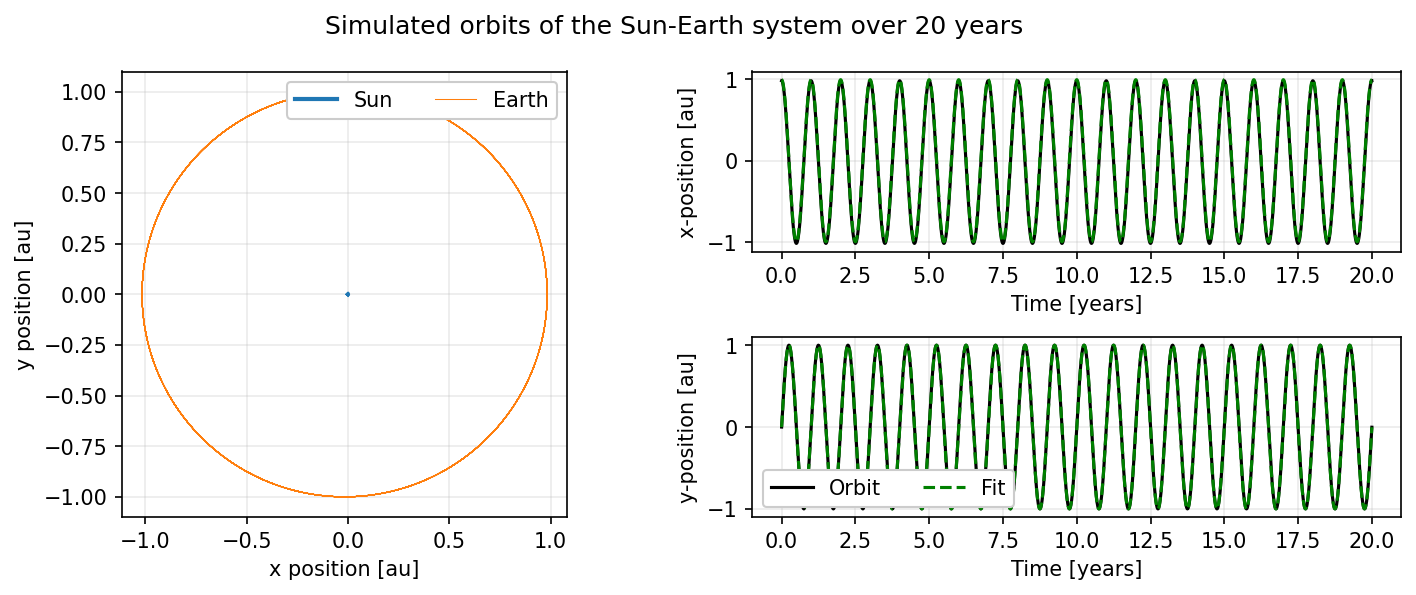

In [150]:
# ----------------------------------------------------------------------------
# Plot the orbit and positions
# ----------------------------------------------------------------------------

fig = plt.figure(figsize=(10,4), dpi=150)

fig.suptitle('Simulated orbits of the Sun-Earth system over 20 years')


ax = plt.subplot(1, 2, 1)
ax.set_aspect('equal')
plt.plot(positions_x[:,0],positions_y[:,0],label=names[0], linewidth=2)
plt.plot(positions_x[:,1],positions_y[:,1],label=names[1], linewidth=0.5)
plt.legend(ncols=2, facecolor='white', framealpha=1)
plt.grid(alpha=0.25)
plt.ylabel('y position [au]')
plt.xlabel('x position [au]')



ax2 = plt.subplot(2, 2, 2)
plt.plot(t_year, positions_x[:,1],zorder=2, color='k')
plt.plot(t_year, func( t_year, *params_xfit ), zorder=5, color='green', alpha=1, linestyle='--')
plt.grid(alpha=0.25)
plt.xlabel('Time [years]')
plt.ylabel('x-position [au]')


ax3 = plt.subplot(2, 2, 4, sharex=ax2,)
plt.plot(t_year, positions_y[:,1], label='Orbit',zorder=2, color='k')
plt.plot(t_year,func( t_year, *params_yfit ),   label='Fit',zorder=5, color='green', alpha=1, linestyle='--')
plt.grid(alpha=0.25)
plt.xlabel('Time [years]')
plt.ylabel('y-position [au]')
plt.legend(ncols=2, facecolor='white', framealpha=1)


plt.tight_layout()

plt.savefig('CodeTest_SunEarth')

In [103]:
# ----------------------------------------------------------------------------
# Calculate period 
# ----------------------------------------------------------------------------
Period_theor = (2*np.pi * np.sqrt( (1*const.au)**3  / (const.G* (const.M_sun))  )).to(u.day).value
print('From Kepler\'s laws, the period of Earth should be {:.3f} days'.format(Period_theor))


Period_xfit = (((2*np.pi ) / params_xfit[1] )*u.year).to(u.day).value
print('From the fit to the x position over time, the period of Earth is {:.3f} days'.format(Period_xfit))

Period_yfit = (((2*np.pi ) / params_yfit[1] )*u.year).to(u.day).value
print('From the fit to the y position over time, the period of Earth is {:.3f} days'.format(Period_yfit))


From Kepler's laws, the period of Earth should be 365.257 days
From the fit to the x position over time, the period of Earth is 365.272 days
From the fit to the y position over time, the period of Earth is 365.259 days


We find a period of Earth that is within +/- 0.02 days of the orbital period of Earth predicted from Kepler's Third Law. Given that the accuracy of this comparision depends on the information inputted into the simulation, result indicates that the simulation is working as expected.  In addition, we do not see the orbit of Earth spiraling in or out which indicates that energy is being conserved very well in this simulation. 

In [148]:
# ----------------------------------------------------------------------------
# Calculate kinetic energy  
# ----------------------------------------------------------------------------

# Find the peak in x (where the particle has returned to its starting postion )
ind = find_peaks(positions_x[:,1])[0]

KineticEnergy = 0.5 * ( velocities_y[:,1][ind]**2 + velocities_x[:,1][ind]**2  )

diffEnergy = np.abs( KineticEnergy[0] -  KineticEnergy[-1] ) / KineticEnergy[0]

print('The percent difference in energy between the end of the first orbit and {} orbits later is {:.3e}'.format( len(ind)-1, diffEnergy) )

The percent difference in energy between the end of the first orbit and 18 orbits later is 1.539e-14


Since the difference in energy is on the order of $10^{-14}$, this would indicate that energy is being conserved. 